In [ ]:
# Loading necessary libraries for data visualization and exploration
import pandas as pd

# Loading the dataset from your local file path
file_path = r'D:\Coventry University\Master\Second semester\Machine learning and big data\movie_dataset.csv'
movie_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataset to understand its structure
print(movie_data.head())

# Getting a summary of the dataset
print(movie_data.info())


   index     budget                                    genres  \
0      0  237000000  Action Adventure Fantasy Science Fiction   
1      1  300000000                  Adventure Fantasy Action   
2      2  245000000                    Action Adventure Crime   
3      3  250000000               Action Crime Drama Thriller   
4      4  260000000          Action Adventure Science Fiction   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  culture clash future space war space colony so...                en   
1  ocean drug abuse exotic island east india trad...                en   
2         spy based on novel sec

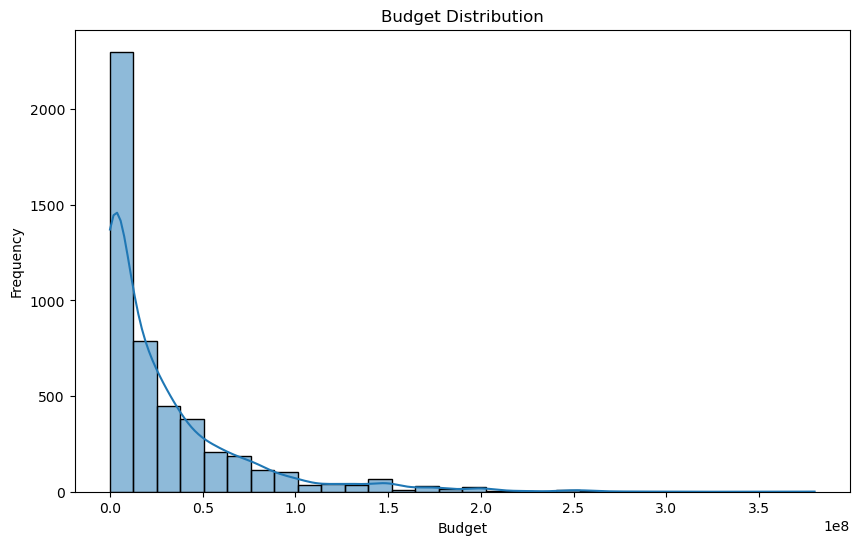

In [ ]:
# Loading necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the distribution of budget
plt.figure(figsize=(10, 6))
sns.histplot(movie_data['budget'], kde=True, bins=30)
plt.title('Budget Distribution')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()


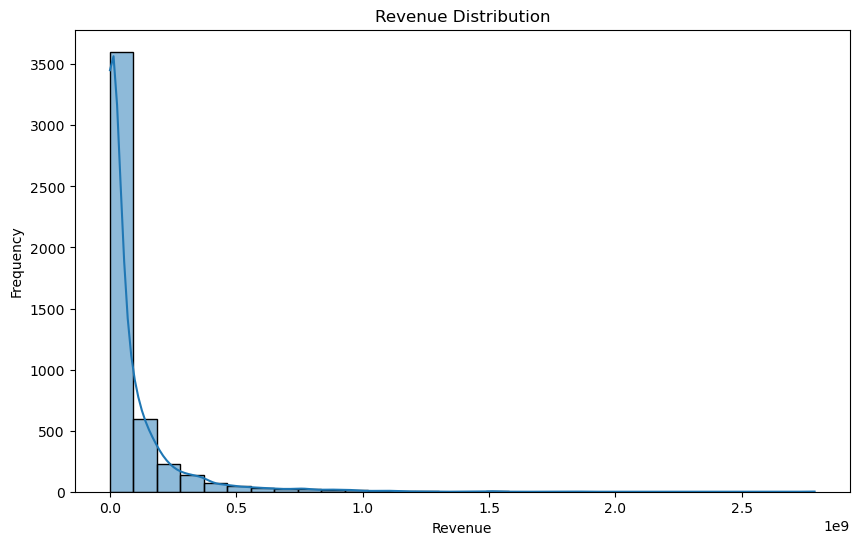

In [ ]:
# Visualizing the distribution of revenue
plt.figure(figsize=(10, 6))
sns.histplot(movie_data['revenue'], kde=True, bins=30)
plt.title('Revenue Distribution')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()


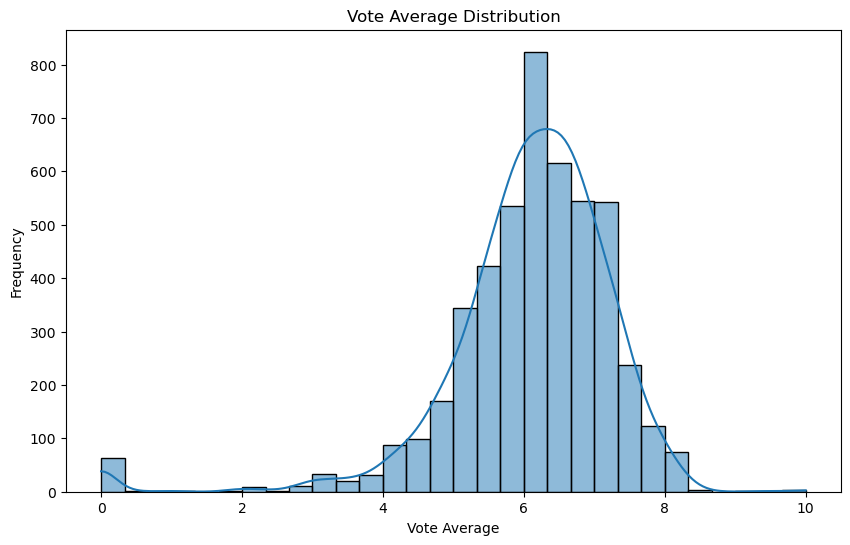

In [ ]:
# Visualizing the distribution of vote average
plt.figure(figsize=(10, 6))
sns.histplot(movie_data['vote_average'], kde=True, bins=30)
plt.title('Vote Average Distribution')
plt.xlabel('Vote Average')
plt.ylabel('Frequency')
plt.show()


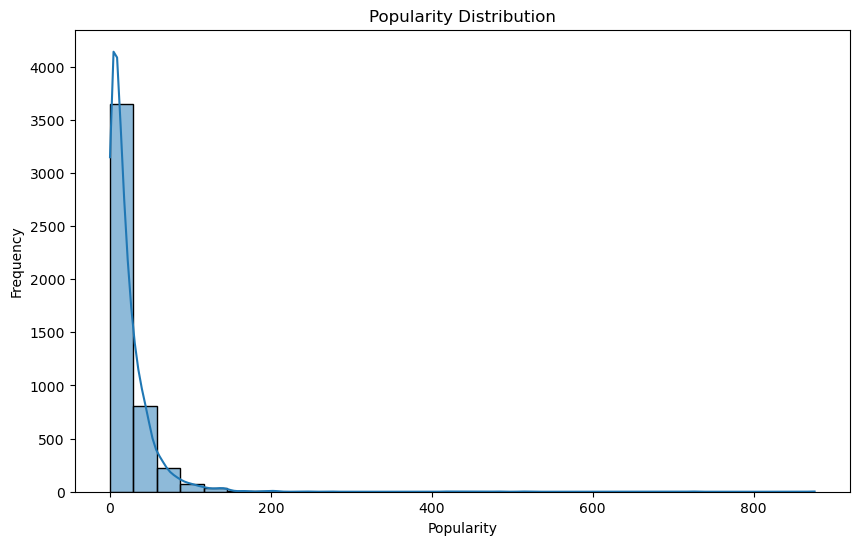

In [ ]:
# Visualizing the distribution of popularity
plt.figure(figsize=(10, 6))
sns.histplot(movie_data['popularity'], kde=True, bins=30)
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Displaying descriptive statistics of the dataset
print(movie_data.describe())


             index        budget             id   popularity       revenue  \
count  4803.000000  4.803000e+03    4803.000000  4803.000000  4.803000e+03   
mean   2401.000000  2.904504e+07   57165.484281    21.492301  8.226064e+07   
std    1386.651002  4.072239e+07   88694.614033    31.816650  1.628571e+08   
min       0.000000  0.000000e+00       5.000000     0.000000  0.000000e+00   
25%    1200.500000  7.900000e+05    9014.500000     4.668070  0.000000e+00   
50%    2401.000000  1.500000e+07   14629.000000    12.921594  1.917000e+07   
75%    3601.500000  4.000000e+07   58610.500000    28.313505  9.291719e+07   
max    4802.000000  3.800000e+08  459488.000000   875.581305  2.787965e+09   

           runtime  vote_average    vote_count  
count  4801.000000   4803.000000   4803.000000  
mean    106.875859      6.092172    690.217989  
std      22.611935      1.194612   1234.585891  
min       0.000000      0.000000      0.000000  
25%      94.000000      5.600000     54.000000  
50%

In [ ]:
# Dropping irrelevant columns
columns_to_drop = ['index', 'homepage', 'id', 'original_title', 'overview', 'status', 'tagline', 'title', 'spoken_languages', 'cast', 'crew']
movie_data.drop(columns=columns_to_drop, inplace=True)


In [ ]:
# Filling missing values in 'genres' and 'keywords' with empty strings
movie_data['genres'] = movie_data['genres'].fillna('')
movie_data['keywords'] = movie_data['keywords'].fillna('')


In [ ]:
# Converting 'release_date' to datetime and extracting useful features like year
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'], errors='coerce')
movie_data['release_year'] = movie_data['release_date'].dt.year
movie_data.drop(columns=['release_date'], inplace=True)


In [ ]:
from sklearn.impute import SimpleImputer

# Imputing missing values for numerical columns
numerical_columns = ['budget', 'runtime', 'vote_average', 'vote_count', 'revenue', 'release_year', 'popularity']
numerical_imputer = SimpleImputer(strategy='mean')
movie_data[numerical_columns] = numerical_imputer.fit_transform(movie_data[numerical_columns])


In [ ]:
# Calculating new features
movie_data['revenue_to_budget_ratio'] = movie_data['revenue'] / (movie_data['budget'] + 1e-9)
movie_data['popularity_to_budget_ratio'] = movie_data['popularity'] / (movie_data['budget'] + 1e-9)


In [ ]:
# Setting thresholds based on analysis
ratio_threshold = 2
popularity_budget_ratio_threshold = 2e-6
vote_count_threshold = 300

# Defining the target variable for success with updated criteria
movie_data['success'] = np.where(
    (movie_data['revenue_to_budget_ratio'] > ratio_threshold) &
    (movie_data['vote_average'] > 7) &
    (movie_data['popularity_to_budget_ratio'] > popularity_budget_ratio_threshold) &
    (movie_data['vote_count'] > vote_count_threshold),
    1,
    0
)


In [ ]:
# One-hot encoding categorical columns
categorical_columns = ['original_language', 'production_countries', 'production_companies', 'director']
movie_data = pd.get_dummies(movie_data, columns=categorical_columns, drop_first=True)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Extracting features from text data
vectorizer = CountVectorizer(max_features=50)
genres_matrix = vectorizer.fit_transform(movie_data['genres']).toarray()
keywords_matrix = vectorizer.fit_transform(movie_data['keywords']).toarray()

# Concatenating the new features with the original dataset
genres_df = pd.DataFrame(genres_matrix, columns=[f'genre_{i}' for i in range(genres_matrix.shape[1])])
keywords_df = pd.DataFrame(keywords_matrix, columns=[f'keyword_{i}' for i in range(keywords_matrix.shape[1])])
movie_data = pd.concat([movie_data, genres_df, keywords_df], axis=1)

# Dropping the original text columns
movie_data.drop(columns=['genres', 'keywords'], inplace=True)


In [ ]:
# Ensuring feature names are valid for XGBoost
movie_data.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_') for col in movie_data.columns]


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X = movie_data.drop(columns=['success'])
y = movie_data['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from imblearn.over_sampling import SMOTE

# Handling data imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)


In [ ]:
from sklearn.preprocessing import StandardScaler

# Applying feature scaling
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Selecting features using RandomForest to reduce overfitting
selector = SelectFromModel(RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42))
selector.fit(X_res, y_res)
X_res = selector.transform(X_res)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initializing and training the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, C=0.00001)
logistic_model.fit(X_train, y_train)


LogisticRegression(C=1e-05, max_iter=1000)

In [ ]:
# Evaluating the Logistic Regression model
y_pred = logistic_model.predict(X_test)
logistic_accuracy = accuracy_score(y_test, y_pred)
logistic_precision = precision_score(y_test, y_pred)
logistic_recall = recall_score(y_test, y_pred)
logistic_f1 = f1_score(y_test, y_pred)
logistic_confusion = confusion_matrix(y_test, y_pred)

print(f'Logistic Regression Test Accuracy: {logistic_accuracy:.2f}')
print(f'Logistic Regression Test Precision: {logistic_precision:.2f}')
print(f'Logistic Regression Test Recall: {logistic_recall:.2f}')
print(f'Logistic Regression Test F1-Score: {logistic_f1:.2f}')
print('Logistic Regression Confusion Matrix:')
print(logistic_confusion)


Logistic Regression Test Accuracy: 0.85
Logistic Regression Test Precision: 0.79
Logistic Regression Test Recall: 0.94
Logistic Regression Test F1-Score: 0.86
Logistic Regression Confusion Matrix:
[[714 223]
 [ 51 848]]


In [ ]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(5, 15),
    'max_depth': [None, 3, 5],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=random_forest_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

best_random_forest_model = random_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initializing and training the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_split=10, min_samples_leaf=5)
random_forest_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=10)

In [ ]:
# Evaluating the Random Forest model
y_pred = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_confusion = confusion_matrix(y_test, y_pred)

print(f'Random Forest Test Accuracy: {rf_accuracy:.2f}')
print(f'Random Forest Test Precision: {rf_precision:.2f}')
print(f'Random Forest Test Recall: {rf_recall:.2f}')
print(f'Random Forest Test F1-Score: {rf_f1:.2f}')
print('Random Forest Confusion Matrix:')
print(rf_confusion)


Random Forest Test Accuracy: 0.85
Random Forest Test Precision: 0.81
Random Forest Test Recall: 0.91
Random Forest Test F1-Score: 0.86
Random Forest Confusion Matrix:
[[746 191]
 [ 77 822]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initializing and training the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(n_estimators=10, max_depth=3, learning_rate=0.01)
gradient_boosting_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.01, n_estimators=10)

In [ ]:
# Evaluating the Gradient Boosting model
y_pred = gradient_boosting_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, y_pred)
gb_precision = precision_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_f1 = f1_score(y_test, y_pred)
gb_confusion = confusion_matrix(y_test, y_pred)

print(f'Gradient Boosting Test Accuracy: {gb_accuracy:.2f}')
print(f'Gradient Boosting Test Precision: {gb_precision:.2f}')
print(f'Gradient Boosting Test Recall: {gb_recall:.2f}')
print(f'Gradient Boosting Test F1-Score: {gb_f1:.2f}')
print('Gradient Boosting Confusion Matrix:')
print(gb_confusion)


Gradient Boosting Test Accuracy: 0.87
Gradient Boosting Test Precision: 0.85
Gradient Boosting Test Recall: 0.89
Gradient Boosting Test F1-Score: 0.87
Gradient Boosting Confusion Matrix:
[[792 145]
 [102 797]]


In [ ]:
from xgboost import XGBClassifier

# Initializing and training the XGBoost model
xgboost_model = XGBClassifier(n_estimators=10, max_depth=3, learning_rate=0.01)
xgboost_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Evaluating the XGBoost model
y_pred = xgboost_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_confusion = confusion_matrix(y_test, y_pred)

print(f'XGBoost Test Accuracy: {xgb_accuracy:.2f}')
print(f'XGBoost Test Precision: {xgb_precision:.2f}')
print(f'XGBoost Test Recall: {xgb_recall:.2f}')
print(f'XGBoost Test F1-Score: {xgb_f1:.2f}')
print('XGBoost Confusion Matrix:')
print(xgb_confusion)


XGBoost Test Accuracy: 0.87
XGBoost Test Precision: 0.85
XGBoost Test Recall: 0.89
XGBoost Test F1-Score: 0.87
XGBoost Confusion Matrix:
[[792 145]
 [102 797]]


In [ ]:
# Evaluating models using cross-validation
models = [logistic_model, random_forest_model, gradient_boosting_model, xgboost_model]
model_names = ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f'{name} CV Accuracy: {np.mean(cv_scores):.2f} (+/- {np.std(cv_scores):.2f})')


Logistic Regression CV Accuracy: 0.84 (+/- 0.01)
Random Forest CV Accuracy: 0.86 (+/- 0.01)
Gradient Boosting CV Accuracy: 0.87 (+/- 0.01)
XGBoost CV Accuracy: 0.87 (+/- 0.01)


Logistic Regression Test Accuracy: 0.85
Logistic Regression Test Precision: 0.79
Logistic Regression Test Recall: 0.94
Logistic Regression Test F1-Score: 0.86
Logistic Regression Confusion Matrix:
[[714 223]
 [ 51 848]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       937
           1       0.79      0.94      0.86       899

    accuracy                           0.85      1836
   macro avg       0.86      0.85      0.85      1836
weighted avg       0.86      0.85      0.85      1836



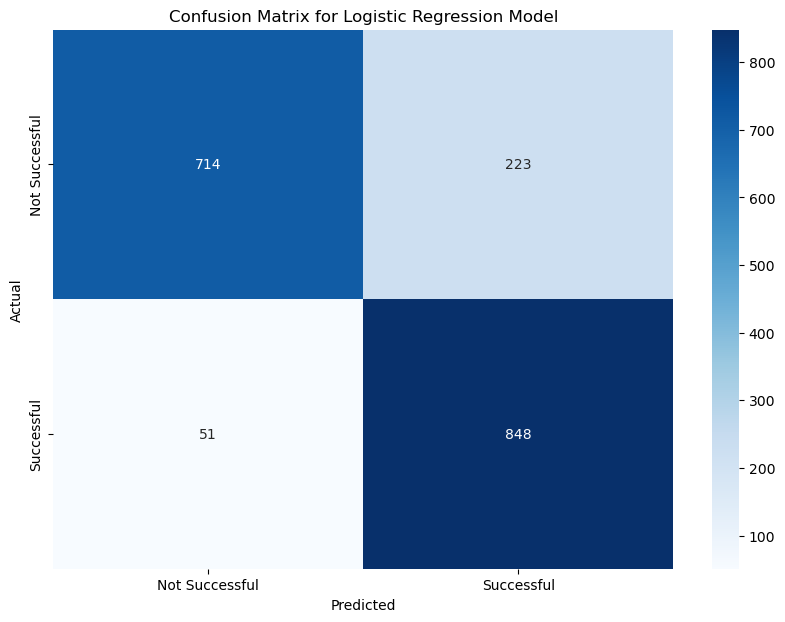

Gradient Boosting Test Accuracy: 0.87
Gradient Boosting Test Precision: 0.85
Gradient Boosting Test Recall: 0.89
Gradient Boosting Test F1-Score: 0.87
Gradient Boosting Confusion Matrix:
[[792 145]
 [102 797]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       937
           1       0.85      0.89      0.87       899

    accuracy                           0.87      1836
   macro avg       0.87      0.87      0.87      1836
weighted avg       0.87      0.87      0.87      1836



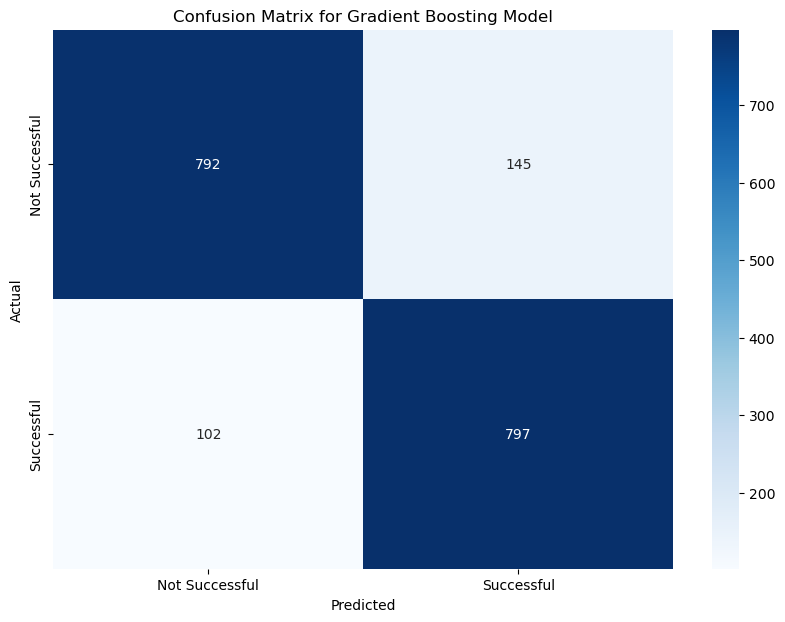

XGBoost Test Accuracy: 0.87
XGBoost Test Precision: 0.85
XGBoost Test Recall: 0.89
XGBoost Test F1-Score: 0.87
XGBoost Confusion Matrix:
[[792 145]
 [102 797]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       937
           1       0.85      0.89      0.87       899

    accuracy                           0.87      1836
   macro avg       0.87      0.87      0.87      1836
weighted avg       0.87      0.87      0.87      1836



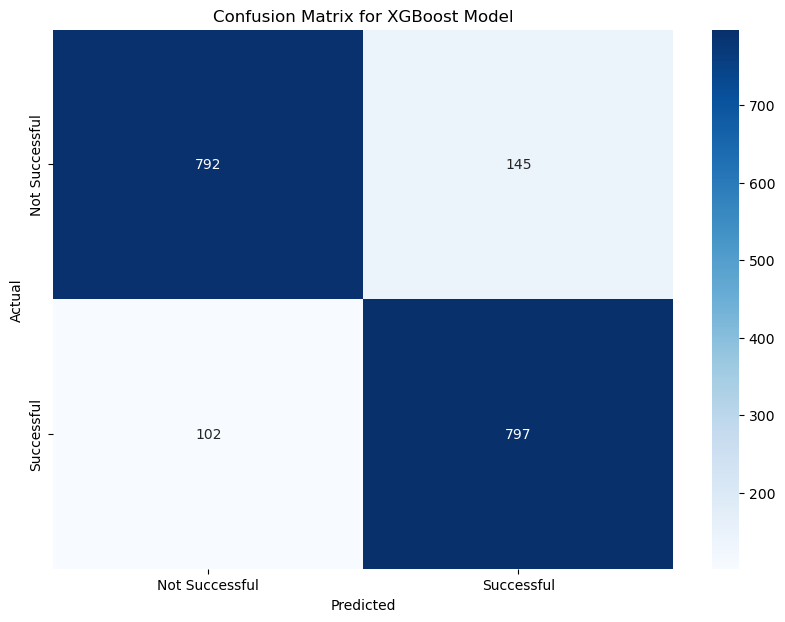

In [ ]:
# Evaluating and visualizing other models
for model, name in zip(models, model_names):
    if name != 'Random Forest':  # We already evaluated and visualized Random Forest
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        print(f'{name} Test Accuracy: {accuracy:.2f}')
        print(f'{name} Test Precision: {precision:.2f}')
        print(f'{name} Test Recall: {recall:.2f}')
        print(f'{name} Test F1-Score: {f1:.2f}')
        print(f'{name} Confusion Matrix:\n{cm}')
        print(classification_report(y_test, y_pred))

        # Plotting confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Successful', 'Successful'], yticklabels=['Not Successful', 'Successful'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {name} Model')
        plt.show()
